In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform_normal = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_shifted = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: torch.roll(x, shifts=4, dims=2)) 
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_normal)
testset_reg = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_normal)
testset_shift = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_shifted)

train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
test_loader_reg = DataLoader(testset_reg, batch_size=64, shuffle=False)
test_loader_shift = DataLoader(testset_shift, batch_size=64, shuffle=False)

print("Data loaded: Training set, Regular Test set, and Shifted Test set ready.")

Data loaded: Training set, Regular Test set, and Shifted Test set ready.


In [ ]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()

        self.main = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        return self.main(x)

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 10)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        return self.fc_layers(x)

fcnn_model = FCNN()
cnn_model = SimpleCNN()
print("Models initialized.")

Models initialized.


In [ ]:
def train_model(model, loader, epochs=3):

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    model.train()

    for epoch in range(epochs):
        for images, labels in loader:
            optimizer.zero_grad()
            loss = criterion(model(images), labels)

            loss.backward()
            optimizer.step()
    print(f"Finished training {model.__class__.__name__}")

def get_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

train_model(fcnn_model, train_loader)
train_model(cnn_model, train_loader)

Finished training FCNN
Finished training SimpleCNN


In [ ]:
fcnn_acc_reg = get_accuracy(fcnn_model, test_loader_reg)
fcnn_acc_shift = get_accuracy(fcnn_model, test_loader_shift)

cnn_acc_reg = get_accuracy(cnn_model, test_loader_reg)
cnn_acc_shift = get_accuracy(cnn_model, test_loader_shift)

print("\n--- ROBUSTNESS DUEL RESULTS ---")
print(f"Model A (FCNN): Regular Acc = {fcnn_acc_reg:.2f}%, Shifted Acc = {fcnn_acc_shift:.2f}%")
print(f"Model B (CNN):  Regular Acc = {cnn_acc_reg:.2f}%, Shifted Acc = {cnn_acc_shift:.2f}%")

print(f"\nFCNN Accuracy Drop: {fcnn_acc_reg - fcnn_acc_shift:.2f}%")
print(f"CNN Accuracy Drop:  {cnn_acc_reg - cnn_acc_shift:.2f}%")


--- ROBUSTNESS DUEL RESULTS ---
Model A (FCNN): Regular Acc = 97.16%, Shifted Acc = 38.18%
Model B (CNN):  Regular Acc = 98.52%, Shifted Acc = 74.87%

FCNN Accuracy Drop: 58.98%
CNN Accuracy Drop:  23.65%


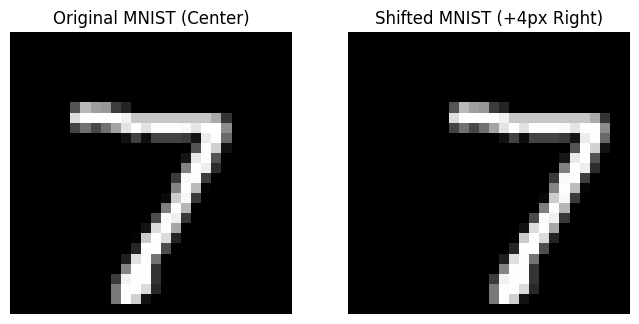

Label: 7


In [ ]:
import matplotlib.pyplot as plt

images_reg, labels_reg = next(iter(test_loader_reg))
images_shift, labels_shift = next(iter(test_loader_shift))

img_reg = images_reg[0].squeeze().numpy()
img_shift = images_shift[0].squeeze().numpy()

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(img_reg, cmap='gray')
axes[0].set_title("Original MNIST (Center)")
axes[0].axis('off')

axes[1].imshow(img_shift, cmap='gray')
axes[1].set_title("Shifted MNIST (+4px Right)")
axes[1].axis('off')

plt.show()
print(f"Label: {labels_reg[0].item()}")